### The main questions of the research is whether a product can be can be classified as a top 5% popular based on early limited data.

In [1]:
import numpy as np 
import pandas as pd

In [2]:
customers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv")
geolocations = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv")
reviews = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv")
order_items = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv")
orders = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv")
order_payments = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv")

products = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv")
product_category_name_translation = pd.read_csv("/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv")
sellers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv")

Data quality check
1. Data Quality Checks (Critical)
This is the core of primary analysis.
- Missing Values
For each feature:
% missing
Pattern of missingness (random vs systematic)
Business meaning of missing values
Examples:
Missing review score → customer didn’t leave a review
Missing delivery date → order not delivered yet
- Duplicates
Check duplicates at the correct grain:
Duplicate orders?
Duplicate order_items per (order_id, product_id)?
- Outliers & Invalid Values
Focus on:
Prices ≤ 0
Negative freight values
Extreme delivery times
Extremely high quantities
Decide:
Remove
Cap
Log-transform
Keep (if business-valid)
- Dtypes

2. Relationship & Join Analysis
Since your data is normalized, you must validate joins.
Key checks:
One-to-one vs one-to-many relationships
Duplicate amplification after joins
Missing foreign keys
Example:
orders → order_items (1-to-many)
orders → reviews (0-or-1-to-1)
orders → payments (1-to-many)
👉 Always test joins with row counts before & after.

3. Temporal Analysis (Very Important for Prediction)
E-commerce data is time-dependent.
Check:
Order timestamps
Delivery timestamps
Review timestamps
Payment timestamps
Ensure:
No future information leaks into the past
Proper time ordering
Correct reference date for features
📌 Example:
If predicting late delivery, you must not use actual delivery date as a feature.

4. Exploratory Data Analysis (EDA)
Now explore distributions and relationships.
- Univariate Analysis
Distribution of prices, freight, delivery time
Review score frequency
Payment method usage
- Bivariate Analysis
Delivery time vs review score
Price vs freight
Payment type vs order value
- Segment Analysis
Customer behavior by location
Seller performance by region
Product category performance

5. Feature Feasibility Assessment
Before feature engineering, decide:
For each candidate feature:
Is it available before prediction time?
Is it stable over time?
Is it aggregated correctly?
Examples:
✅ Average delivery delay per seller (past data)
❌ Final review score when predicting delivery delay

6. Granularity Alignment
Choose one modeling level:
Order-level
Customer-level
Product-level
Seller-level
Then aggregate everything to that level.
Example (Order-level model):
Number of items in order
Total order value
Average seller delivery delay (historical)
Customer historical purchase count

7. Target Variable Validation
Check your target:
Class balance (for classification)
Distribution shape (for regression)
Noise and ambiguity
Example:
Review score may be subjective
Delivery delay threshold must be business-defined

8. Data Leakage Audit (Must-Have)
Ask for every feature:
“Would I know this at prediction time?”
Common leakage risks in your datasets:
Using review data to predict delivery
Using delivery date to predict order cancellation
Using future customer behavior

9. Output of Primary Data Analysis
At the end, you should have:
✔ Clean, validated tables
✔ Defined joins and aggregation logic
✔ List of usable features
✔ List of discarded features
✔ Defined prediction timestamp
✔ Clear modeling grain
✔ Leakage-free dataset








Future plans:
1. calculate a metric which will score product popularity or comercial success

As i am planning to build the model for prediction, i need to understand what kind of data i have. \
The model will be a binary (or three class) classifier. \
I need to construct target variable. Then i will be able to explore class balance.\


## 1. Data Quality Check

### 1.1. NAs Check

In [3]:
datasets = {"customers": customers,
            "geolocation": geolocations,
            "reviews": reviews,
            "order_items": order_items,
            "orders": orders,
            "order_payments": order_payments,
            "products": products,
            "product_category_name_translation": product_category_name_translation, 
            "sellers":sellers}
for name, ds in datasets.items():
    print(name.ljust(50, "#"))
    print(ds.info(), "\n")

customers#########################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None 

geolocation#######################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2 

The tables that have NAs 

reviews:
- review_comment_title
- review_comment_message


orders:
- order_delivered_carrier_date
- order_delivered_customer_date
- order_approved_at



products: (NAs are just values someone forgot to fill in - no interpretaion)
- product_category_name
- product_name_lenght
- product_description_lenght
- product_photos_qty 


In [4]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [5]:
print(
f"""
both are null: {orders[pd.isnull(orders.order_delivered_carrier_date) &
        pd.isna(orders.order_delivered_customer_date)].shape[0]}
        
customer date is not null: {orders[pd.isnull(orders.order_delivered_carrier_date) &
        pd.notna(orders.order_delivered_customer_date)].shape[0]}
        
carrier date is not null: {orders[pd.notnull(orders.order_delivered_carrier_date) &
        pd.isna(orders.order_delivered_customer_date)].shape[0]}
"""
)


both are null: 1782
        
customer date is not null: 1
        
carrier date is not null: 1183



In [6]:
orders[pd.isna(orders.order_approved_at)].value_counts("order_status")

order_status
canceled     141
delivered     14
created        5
Name: count, dtype: int64

### 1.2 Dealing with NAs

reviews:\
I will not use reviews table columns: review_comment_title	and review_comment_message for prediction model construction as they have to many missing values.

orders:\
I will not use delivery dates for model construction as it has no relation to product popularity.


In [7]:
na_cols = ["product_category_name",
"product_name_lenght",
"product_description_lenght",
"product_photos_qty"]

mask_all = products[na_cols].isna().all(axis=1)

#check if NaN values are in the same rows for all the columns listed in na_cols
assert all([products[products[c].isna()].shape == products[mask_all].shape for  c in na_cols])

All the rows with NaN in na_cols can be dropped as NaN values are in the same rows for all the columns listed in na_cols.

### 1.3. Duplicated IDs

Some of the reviews are duplicated with only order id changed. That might mean that riviews can have more than one order id.

In [8]:
reviews[reviews.review_id == reviews[reviews.review_id.duplicated()].iloc[1, 0]]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
4545,308316408775d1600dad81bd3184556d,27e5ed2ecefbe0bcc9ae0c9b26b763c3,5,NaN,Ajudem a rastrear uma das 3 prateleiras que fa...,2017-09-07 00:00:00,2017-09-11 09:58:09
5719,308316408775d1600dad81bd3184556d,3fe4dbcdb046a475dbf25463c1ca78bd,5,NaN,Ajudem a rastrear uma das 3 prateleiras que fa...,2017-09-07 00:00:00,2017-09-11 09:58:09
53661,308316408775d1600dad81bd3184556d,8b3c2785144e72ccba9b0213f0f1cd1e,5,NaN,Ajudem a rastrear uma das 3 prateleiras que fa...,2017-09-07 00:00:00,2017-09-11 09:58:09


However the orders look different.

In [9]:
order_ids = reviews[reviews.review_id == reviews[reviews.review_id.duplicated()].iloc[1, 0]].order_id
orders.loc[orders.order_id.isin(order_ids)]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3804,3fe4dbcdb046a475dbf25463c1ca78bd,e17387227a12c3cac59fc44523d162e5,delivered,2017-08-30 06:22:58,2017-08-30 07:00:08,2017-08-30 20:43:45,2017-09-06 18:42:36,2017-09-26 00:00:00
14178,8b3c2785144e72ccba9b0213f0f1cd1e,e6138dce24962a66623898c89db41ef7,delivered,2017-08-30 06:22:57,2017-08-30 07:00:05,2017-08-30 20:43:45,2017-09-06 20:27:43,2017-09-26 00:00:00
55653,27e5ed2ecefbe0bcc9ae0c9b26b763c3,9962a28bb74e0754415433c3ddc14b2f,delivered,2017-08-30 06:22:58,2017-08-30 07:00:06,2017-08-30 20:43:45,2017-09-11 21:06:49,2017-09-26 00:00:00


Some orders have more than one payment.

In [10]:
order_payments[order_payments.order_id.duplicated()].shape

(4446, 5)

However all the payments are unique

In [11]:
order_payments[order_payments.duplicated()].shape

(0, 5)

Non of the order ids are duplicated

In [12]:
orders[orders.order_id.duplicated()].shape

(0, 8)

In [13]:
customers[customers.customer_id.duplicated()].shape, customers[customers.customer_unique_id.duplicated()].shape

((0, 5), (3345, 5))

In [14]:
products[products.product_id.duplicated()].shape

(0, 9)

In [15]:
order_items[order_items.duplicated()].shape

(0, 7)

In [16]:
sellers[sellers.seller_id.duplicated()].shape

(0, 4)

261831 of geolocations are duplicated in geolocations dataset

In [17]:
geolocations[geolocations.duplicated()].shape

(261831, 5)

## 2. Relationship & Join Analysis

![My image](https://i.imgur.com/HRhd2Y0.jpg)

olist_order_customers_dataset.csv name was changed to olist_customers_dataset.csv

### 2.1 one-to-one

Check whether any missing values, duplicates or another problems appear when merging one to one.

In [18]:
orders.shape, customers.shape

((99441, 8), (99441, 5))

In [19]:
pd.merge(orders, customers).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
 8   customer_unique_id             99441 non-null  object
 9   customer_zip_code_prefix       99441 non-null  int64 
 10  customer_city                  99441 non-null  object
 11  customer_state                 99441 non-null  object
dtypes: int64(1), object(11)
memory usage: 9.1+ MB


In [20]:
pd.merge(order_items, products).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   order_id                    112650 non-null  object 
 1   order_item_id               112650 non-null  int64  
 2   product_id                  112650 non-null  object 
 3   seller_id                   112650 non-null  object 
 4   shipping_limit_date         112650 non-null  object 
 5   price                       112650 non-null  float64
 6   freight_value               112650 non-null  float64
 7   product_category_name       111047 non-null  object 
 8   product_name_lenght         111047 non-null  float64
 9   product_description_lenght  111047 non-null  float64
 10  product_photos_qty          111047 non-null  float64
 11  product_weight_g            112632 non-null  float64
 12  product_length_cm           112632 non-null  float64
 13  product_height

### 2.2 many-to-one

In [21]:
reviews.shape, orders.shape

((99224, 7), (99441, 8))

In [22]:
pd.merge(reviews, orders).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   review_id                      99224 non-null  object
 1   order_id                       99224 non-null  object
 2   review_score                   99224 non-null  int64 
 3   review_comment_title           11568 non-null  object
 4   review_comment_message         40977 non-null  object
 5   review_creation_date           99224 non-null  object
 6   review_answer_timestamp        99224 non-null  object
 7   customer_id                    99224 non-null  object
 8   order_status                   99224 non-null  object
 9   order_purchase_timestamp       99224 non-null  object
 10  order_approved_at              99068 non-null  object
 11  order_delivered_carrier_date   97468 non-null  object
 12  order_delivered_customer_date  96359 non-null  object
 13  o

In [23]:
order_payments.shape, orders.shape, 

((103886, 5), (99441, 8))

In [24]:
pd.merge(order_payments, orders).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       103886 non-null  object 
 1   payment_sequential             103886 non-null  int64  
 2   payment_type                   103886 non-null  object 
 3   payment_installments           103886 non-null  int64  
 4   payment_value                  103886 non-null  float64
 5   customer_id                    103886 non-null  object 
 6   order_status                   103886 non-null  object 
 7   order_purchase_timestamp       103886 non-null  object 
 8   order_approved_at              103711 non-null  object 
 9   order_delivered_carrier_date   101998 non-null  object 
 10  order_delivered_customer_date  100754 non-null  object 
 11  order_estimated_delivery_date  103886 non-null  object 
dtypes: float64(1), int64(2), objec

Some orders have two or more payments.

In [25]:
# order_payments[order_payments.duplicated("order_id")].sort_values(by="order_id")

order_payments.loc[order_payments.order_id == "009ac365164f8e06f59d18a08045f6c4", :]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
285,009ac365164f8e06f59d18a08045f6c4,5,voucher,1,8.75
15298,009ac365164f8e06f59d18a08045f6c4,6,voucher,1,4.17
16053,009ac365164f8e06f59d18a08045f6c4,1,credit_card,1,0.88
16459,009ac365164f8e06f59d18a08045f6c4,2,voucher,1,4.50
32058,009ac365164f8e06f59d18a08045f6c4,4,voucher,1,5.45
73837,009ac365164f8e06f59d18a08045f6c4,3,voucher,1,8.25


In [26]:
pd.merge(order_items, orders).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   order_item_id                  112650 non-null  int64  
 2   product_id                     112650 non-null  object 
 3   seller_id                      112650 non-null  object 
 4   shipping_limit_date            112650 non-null  object 
 5   price                          112650 non-null  float64
 6   freight_value                  112650 non-null  float64
 7   customer_id                    112650 non-null  object 
 8   order_status                   112650 non-null  object 
 9   order_purchase_timestamp       112650 non-null  object 
 10  order_approved_at              112635 non-null  object 
 11  order_delivered_carrier_date   111456 non-null  object 
 12  order_delivered_customer_date 

In [27]:
geolocations.shape, customers.shape

((1000163, 5), (99441, 5))

In [28]:
pd.merge(customers,
         geolocations, 
         left_on="customer_zip_code_prefix", 
         right_on="geolocation_zip_code_prefix").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15083455 entries, 0 to 15083454
Data columns (total 10 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   customer_id                  object 
 1   customer_unique_id           object 
 2   customer_zip_code_prefix     int64  
 3   customer_city                object 
 4   customer_state               object 
 5   geolocation_zip_code_prefix  int64  
 6   geolocation_lat              float64
 7   geolocation_lng              float64
 8   geolocation_city             object 
 9   geolocation_state            object 
dtypes: float64(2), int64(2), object(6)
memory usage: 1.1+ GB


The analysis of this merge will stop there because this merge is to large to count non null values and also geolocations of customers will not be necessary for model.

In [29]:
order_items.shape, sellers.shape

((112650, 7), (3095, 4))

In [30]:
pd.merge(sellers, order_items).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   seller_id               112650 non-null  object 
 1   seller_zip_code_prefix  112650 non-null  int64  
 2   seller_city             112650 non-null  object 
 3   seller_state            112650 non-null  object 
 4   order_id                112650 non-null  object 
 5   order_item_id           112650 non-null  int64  
 6   product_id              112650 non-null  object 
 7   shipping_limit_date     112650 non-null  object 
 8   price                   112650 non-null  float64
 9   freight_value           112650 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 8.6+ MB


Seller dataset and geolocation dataset merge will not be analysed because it is to large

## 3. Temporal Analysis

There will not be a temporal analysis because time features will not be used for model construction.

## 4. EDA

<Axes: xlabel='review_score'>

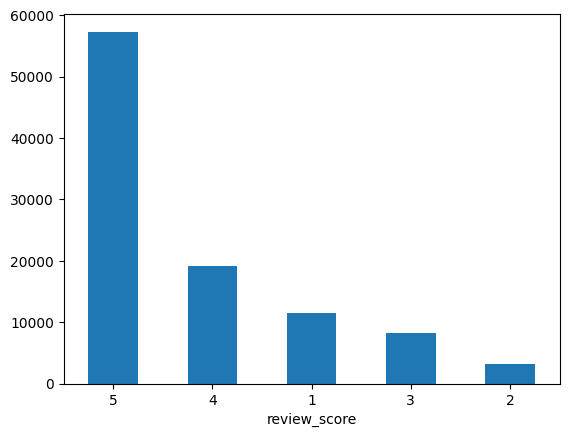

In [31]:
reviews.review_score.value_counts().plot.bar(x="review_score", rot=0)

From this plot we can say that review_scores will not be a valuable feature to identify potentialy popular products as the majority of ordrs are scored as 5.

<Axes: xlabel='payment_sequential'>

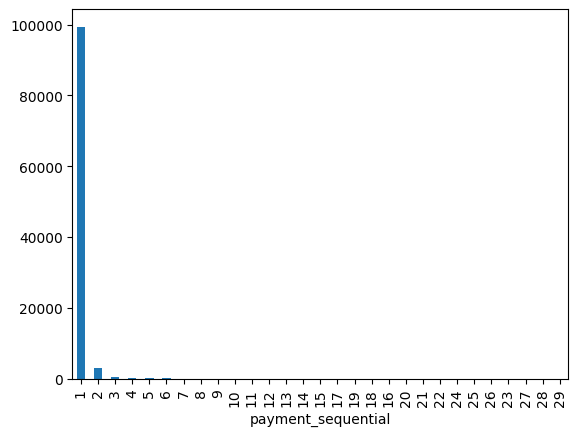

In [32]:
order_payments.payment_sequential.value_counts().plot.bar(x="index")

In [33]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
